# Data Loading

Load the dataset from hugging face and check the data structure.

In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [3]:
from datasets import load_dataset
ds = load_dataset("Yelp/yelp_review_full")
print(ds)
print(ds['train'][0])

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})
{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}


# Model 1: TF-IDF model with logistic regression

Import the libraries.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
import itertools
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Use these codes to get more stopwords. These stopwords, although very frequent, are not helpful for determining the star rating of user reviews.

In [5]:
#all_words = list(itertools.chain.from_iterable(df_1['clean_text'].str.split()))
#word_freq = Counter(all_words)
#common_words = word_freq.most_common(50)
#for word, count in common_words:
#    print(f"{word}: {count}")

Write text-cleaning function to clean data.

In [6]:
# use part of the dataset for training and testing
sample_size = 100000
df_1 = pd.DataFrame(ds['train'][:sample_size])

# text cleaning
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'food', 'order', 'place', 'restaurant', 'get', 'come', 'one',
    'service', 'time', 'staff', 'location', 'table', 'menu',
    'ordered', 'went', 'back', 'said', 'asked', 'told', 'good', 'go','got'
}
combined_stopwords = stop_words.union(custom_stopwords)

def clean_text(t):
    t = t.lower()
    t = re.sub(f"[{re.escape(string.punctuation)}]", "", t)
    words = t.split()
    words = [stemmer.stem(w) for w in words if w not in combined_stopwords]
    return " ".join(words)

df_1['clean_text'] = df_1['text'].apply(clean_text)
df_1['label'] = df_1['label']

Split the dataset and vectorize it using TF-IDF

In [7]:
# split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(df_1['clean_text'], df_1['label'], test_size=0.2, random_state=42)

# vectorize the text data using TF-IDF
vectorize = TfidfVectorizer(max_features=30000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = vectorize.fit_transform(X_train)
X_test_tfidf = vectorize.transform(X_test)

Do logistic regression and use cross validation to pick hyperparameter.

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
model = LogisticRegressionCV(
    Cs=[0.1, 1, 10],
    cv=3,
    multi_class='multinomial',
    solver='saga',
    max_iter=10000,
    class_weight='balanced',
    scoring='accuracy',
    verbose=1
)

model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# compare the predicted and actual labels to get accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


convergence after 22 epochs took 4 seconds
convergence after 23 epochs took 3 seconds
convergence after 56 epochs took 6 seconds
convergence after 24 epochs took 3 seconds
convergence after 22 epochs took 3 seconds
convergence after 57 epochs took 6 seconds
convergence after 22 epochs took 4 seconds
convergence after 21 epochs took 2 seconds
convergence after 59 epochs took 6 seconds
Accuracy: 0.56465
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      4599
           1       0.51      0.49      0.50      4085
           2       0.48      0.45      0.47      3880
           3       0.48      0.45      0.47      3914
           4       0.59      0.66      0.62      3522

    accuracy                           0.56     20000
   macro avg       0.56      0.56      0.56     20000
weighted avg       0.56      0.56      0.56     20000



Get the confusion matrix.

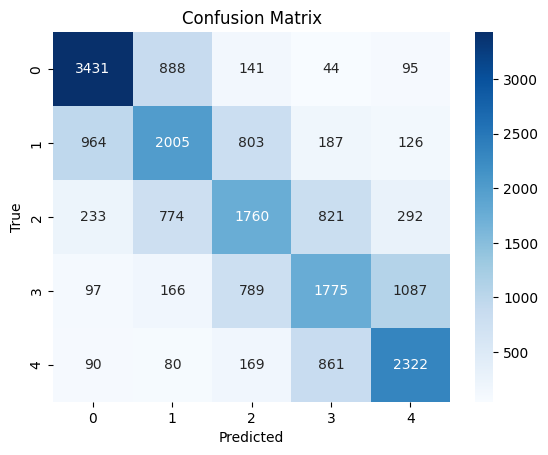

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Draw wordcloud for 1-5 stars reviews.

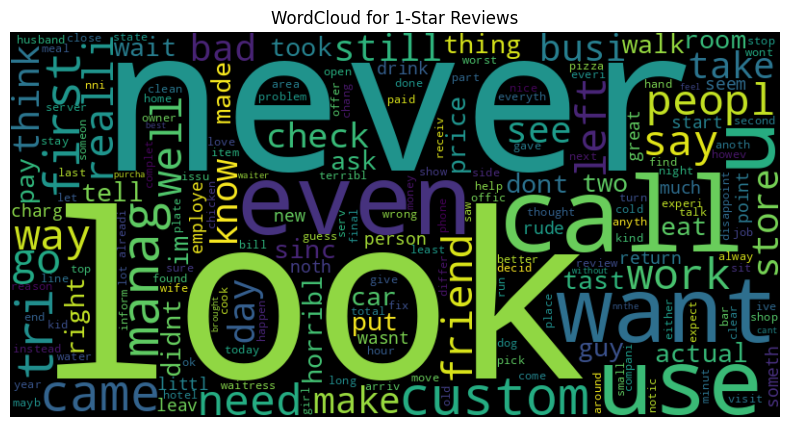

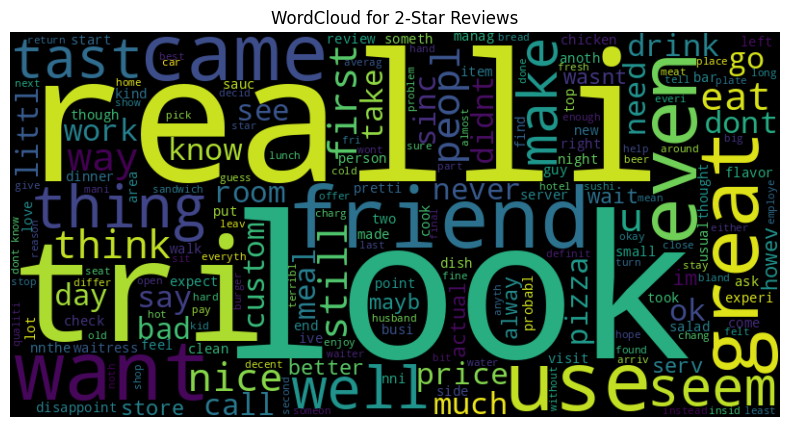

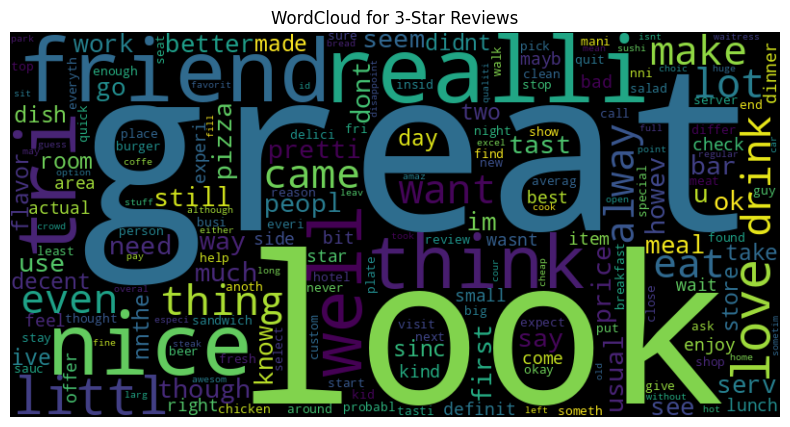

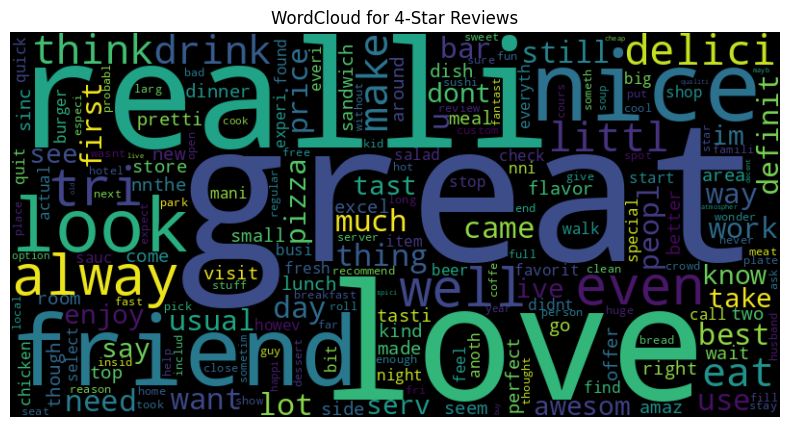

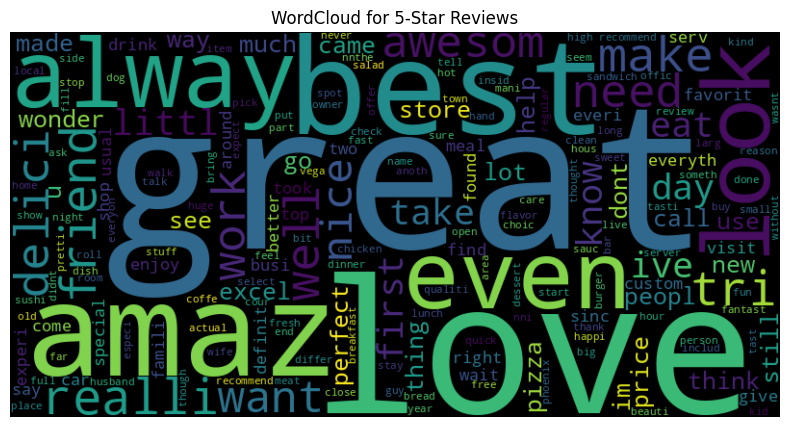

In [11]:
from wordcloud import WordCloud

for label in range(5):
    text = " ".join(df_1[df_1['label'] == label]['clean_text'])
    wc = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {label+1}-Star Reviews")
    plt.show()

# Model 2: Distilbert

In [7]:
from datasets import load_dataset
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = load_dataset("yelp_review_full")
df_2 = pd.DataFrame(dataset['train'][:10000])
df_2['label'] = df_2['label'].astype(int)
df_2 = df_2[['text', 'label']]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
dataset_hf = Dataset.from_pandas(df_2)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset_hf.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
val_dataset = split['test']

In [10]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
training_args = TrainingArguments(
    output_dir="./distilbert-yelp",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

<ipython-input-11-74adecefed08>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,1.332400
1000,1.098400
1500,1.055600
2000,1.000800
2500,0.843200
3000,0.872600
3500,0.815100
4000,0.820300
4500,0.592900
5000,0.584500


TrainOutput(global_step=6000, training_loss=0.8536342315673828, metrics={'train_runtime': 730.7305, 'train_samples_per_second': 32.844, 'train_steps_per_second': 8.211, 'total_flos': 1589693829120000.0, 'train_loss': 0.8536342315673828, 'epoch': 3.0})

In [12]:
trainer.evaluate()

{'eval_loss': 1.1955974102020264,
 'eval_accuracy': 0.5865,
 'eval_f1': 0.5858120261968791,
 'eval_precision': 0.5856073942988643,
 'eval_recall': 0.5865,
 'eval_runtime': 14.1381,
 'eval_samples_per_second': 141.461,
 'eval_steps_per_second': 8.841,
 'epoch': 3.0}

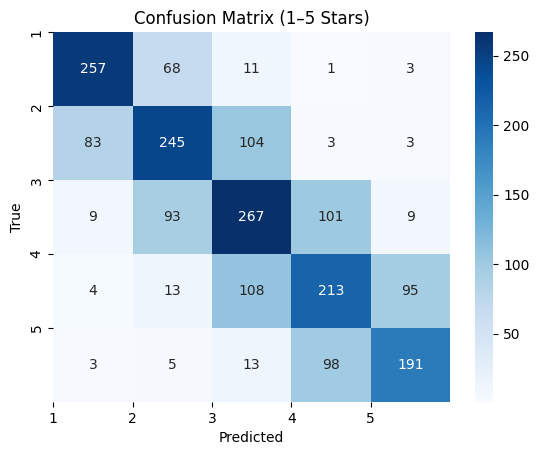

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

outputs = trainer.predict(val_dataset)
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (1–5 Stars)")
plt.xticks(ticks=[0,1,2,3,4], labels=['1','2','3','4','5'])
plt.yticks(ticks=[0,1,2,3,4], labels=['1','2','3','4','5'])
plt.show()